# Accessing AIGFS forecast output from the Unidata THREDDS Data Server using Siphon and MetPy

## Notebook Goal

Use Siphon and Metpy to load the latest run of the AIGFS into an xarray dataset based on the [AIGFS catalog](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html) from the Unidata THREDDS Data Server.


## Requirements
The following reads from the included `env.yml` conda environment file.

In [1]:
with open("env.yml") as f:
    print(f.read())

name: aigfs-announcement
channels:
  - conda-forge
dependencies:
  - python>=3.14
  - siphon
  - metpy
  - jupyter




In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, UTC
import matplotlib.pyplot as plt
import numpy as np

from metpy.units import units
from siphon.catalog import TDSCatalog

### Open the Remote Dataset

Use Siphon to parse the THREDDS client catalog for the AIGFS dataset from the [NSF Unidata TDS](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html), or the [University of Wisconsin - Madison department of Atmospheric and Oceanic Sciences TDS](https://thredds.aos.wisc.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.html), and remotely open the latest dataset using xarray and metpy accessors.
Note that very little data is transfered in this process; at no point will we download the entire 5+ GiB of grib messages.

In [3]:
catalog_url = 'https://thredds.ucar.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.xml'
# uncomment below to access data from the University of Wisconsin - Madison
# department of Atmospheric and Oceanic Sciences TDS
#catalog_url = 'https://thredds.aos.wisc.edu/thredds/catalog/grib/NCEP/AIGFS/Global_0p25deg/catalog.xml'
cat = TDSCatalog(catalog_url)
ds = cat.latest.remote_access(use_xarray=True).metpy.parse_cf()
ds

<xarray.Dataset> Size: 23GB
Dimensions:                                                   (time1: 127, : 2,
                                                               lat: 721,
                                                               lon: 1440,
                                                               time: 65,
                                                               isobaric: 13,
                                                               height_above_ground1: 1,
                                                               height_above_ground: 1)
Coordinates:
  * time1                                                     (time1) datetime64[ns] 1kB ...
  * lat                                                       (lat) >f4 3kB 9...
  * lon                                                       (lon) >f4 6kB 0...
  * time                                                      (time) datetime64[ns] 520B ...
  * isobaric                                                  (isobaric) >f4 52B ...
  * height_above_ground1                                      (height_above_ground1) >f4 4B ...
  * height_above_ground                                       (height_above_ground) >f4 4B ...
    reftime                                                   datetime64[ns] 8B ...
    metpy_crs                                                 object 8B Proje...
Dimensions without coordinates: 
Data variables: (12/13)
    LatLon_Projection                                         int32 4B ...
    time1_bounds                                              (time1, ) datetime64[ns] 2kB ...
    Geopotential_height_isobaric                              (time, isobaric, lat, lon) float32 4GB ...
    Pressure_reduced_to_MSL_msl                               (time, lat, lon) float32 270MB ...
    Specific_humidity_isobaric                                (time, isobaric, lat, lon) float32 4GB ...
    Temperature_isobaric                                      (time, isobaric, lat, lon) float32 4GB ...
    ...                                                        ...
    Total_precipitation_surface_Mixed_intervals_Accumulation  (time1, lat, lon) float32 527MB ...
    Vertical_velocity_pressure_isobaric                       (time, isobaric, lat, lon) float32 4GB ...
    u-component_of_wind_isobaric                              (time, isobaric, lat, lon) float32 4GB ...
    u-component_of_wind_height_above_ground                   (time, height_above_ground, lat, lon) float32 270MB ...
    v-component_of_wind_isobaric                              (time, isobaric, lat, lon) float32 4GB ...
    v-component_of_wind_height_above_ground                   (time, height_above_ground, lat, lon) float32 270MB ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   2,1
    Type_of_generating_process:           Forecast
    file_format:                          GRIB-2
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.internal.dataset.conv.CF1C...

Let's inspect the `Temperature_height_above_ground` variable, which as shown by the metadata, is the Temperature in Kelvin at 2.0m above ground level:

In [4]:
temperature = ds['Temperature_height_above_ground']
temperature

<xarray.DataArray 'Temperature_height_above_ground' (time: 65,
                                                     height_above_ground1: 1,
                                                     lat: 721, lon: 1440)> Size: 270MB
[67485600 values with dtype=float32]
Coordinates:
  * time                  (time) datetime64[ns] 520B 2026-01-16T18:00:00 ... ...
  * height_above_ground1  (height_above_ground1) >f4 4B 2.0
  * lat                   (lat) >f4 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon                   (lon) >f4 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    reftime               datetime64[ns] 8B 2026-01-16T18:00:00
    metpy_crs             object 8B Projection: latitude_longitude
Attributes: (12/13)
    long_name:                       Temperature @ Specified height level abo...
    units:                           K
    abbreviation:                    TMP
    grid_mapping:                    LatLon_Projection
    Grib_Variable_Id:                VAR_0-0-0_L103
    Grib2_Parameter:                 [0 0 0]
    ...                              ...
    Grib2_Parameter_Category:        Temperature
    Grib2_Parameter_Name:            Temperature
    Grib2_Level_Type:                103
    Grib2_Level_Desc:                Specified height level above ground
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1

Let's do some data wrangling. We can use some `datetime` arithmetic to find the valid forecast time for our desired forecast hours--in this case, hour `30`. We will use that calculated time to subset our DataArray using `.sel()`. This subsetting can be done before we ever download or stream any values.

Now, given our 2-D slice of temperature for our forecast hour, we can take a few extra steps to `.squeeze()` out any unnecessary dimensions and use MetPy's xarray functionality to convert our Temperature field to units of degrees Celcius.

In [5]:
forecast_hour = 30
forecast_valid = temperature.reftime + np.timedelta64(forecast_hour, 'h')

forecast_temperature = temperature.metpy.sel(time=forecast_valid).squeeze().metpy.convert_units("degC")
forecast_temperature

Magnitude,[[-29.849990844726562 -29.849990844726562 -29.849990844726562 ... -29.949996948242188 -29.849990844726562 -29.849990844726562] [-30.149993896484375 -30.149993896484375 -30.25 ... -30.149993896484375 -30.149993896484375 -30.25] [-30.25 -30.25 -30.25 ... -30.25 -30.25 -30.25] ... [-28.949996948242188 -28.949996948242188 -28.949996948242188 ... -28.849990844726562 -28.849990844726562 -28.949996948242188] [-27.949996948242188 -27.949996948242188 -27.849990844726562 ... -27.849990844726562 -27.849990844726562 -27.949996948242188] [-27.949996948242188 -28.04998779296875 -27.949996948242188 ... -27.949996948242188 -27.949996948242188 -27.949996948242188]]
Units,degree_Celsius


Finally, let's display a map of the two-meter temperature in degrees Celsius. Also note that up until this point, we've only read a minimal amount of data and metadata from the server. **Again, at no point do we download the entire 5+ GiB of GRIB records from the server.**

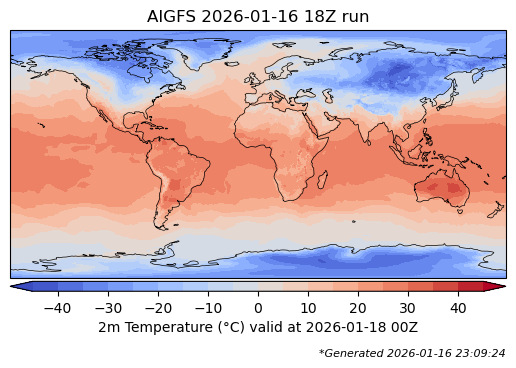

In [6]:
generation_time = datetime.now(UTC).strftime("%Y-%m-%d %H:%M:%S")
run_time = forecast_temperature.reftime.dt.strftime("%Y-%m-%d %H").values
valid_time = forecast_temperature.metpy.time.dt.strftime("%Y-%m-%d %H").values

temperature_range = np.arange(-45, 46, 5) * units.degC
plot_projection = ccrs.PlateCarree()

fig = plt.figure()
ax = plt.axes(projection=plot_projection)

cax = ax.contourf(
    forecast_temperature.metpy.longitude, forecast_temperature.metpy.latitude,
    forecast_temperature,
    temperature_range, cmap='coolwarm', extend='both',
    transform=forecast_temperature.metpy.cartopy_crs)

cb = plt.colorbar(
    cax, orientation='horizontal', pad=0.01, aspect=50, extend=True,
    label=f'2m Temperature ({forecast_temperature.metpy.units:~P}) valid at {valid_time}Z')

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

ax.set_title(f'AIGFS {run_time}Z run')

figtext = plt.figtext(
    0.9, 0.07,
    f'*Generated {generation_time}',
    horizontalalignment='right',
    fontsize=8,
    style='italic')